In [1]:
#clear all varaibles
%reset

In [2]:
# Basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.special import legendre
from mpmath import coulombf, coulombg, mp
from scipy.interpolate import interp1d
import csv


In [4]:
def gamma_calc(m1, m2, m3, m4, en1, Q):
    """
    Calculates the gamma value for a given nuclear reaction based on the input parameters.
    Uses notation from "The Atomic Nucleus", Chapter 12: Conservation Laws for Nuclear Reactions, problem 17

    Args:
        m1 (float): Mass of particle 1.
        m2 (float): Mass of particle 2.
        m3 (float): Mass of particle 3.
        m4 (float): Mass of particle 4.
        en1 (float): Energy of particle 1.
        Q (float): Q-value of the reaction.

    Returns:
        float: The gamma value of the reaction.
    """
    # Calculate gamma value using the input parameters.
    return np.sqrt(m1*m3/(m2*m4)*en1/(en1+Q*(1+m1/m2)))

def en3_calc(m1, m3, m4, theta_L_deg, Q, en1):
    """
        Calculate the energy of a particle produced.

        Args:
            m1 (float): mass of the initial particle
            m3 (float): mass of the product particle that is being solved
            m4 (float): mass of the product particle
            theta_L_deg (float or array-like): scattering angle in degrees
            Q (float): Q-value of reaction
            en1 (float): energy of the initial particle

        Returns:
            np.array: array of the final particle energies for each scattering angle in theta_L
        """
    # Convert to numpy arrays
    m1 = np.asarray( m1, dtype=float)
    m3 = np.asarray( m3, dtype=float)
    m4 = np.asarray( m4, dtype=float)
    Q = np.asarray( Q, dtype=float)
    en1 = np.asarray( en1, dtype=float)

    # Convert theta_L to radians for later use in calculations.
    theta_L = np.radians(theta_L_deg)

    # Calculate intermediate quantities v and w.
    v = np.sqrt(m1*m3*en1)/(m3+m4)*np.cos(theta_L)
    w = (m4*Q+en1*(m4-m1))/(m3+m4)
    
    # Calculate and remove negative values in the energy calculation.
    en_test = v**2+w
    # Get rid of negative due to roundoff
    en_test = np.where(en_test >= 0.0, en_test,np.nan)

    # Calculate the final energies of the particle by adding/subtracting the square root of the positive/negative energy part.
    e3p_sqrt = v + np.sqrt(en_test)
    e3n_sqrt = v - np.sqrt(en_test)

    # Check if energies are negative by setting negative values to NaN.
    e3p_sqrt = np.where(e3p_sqrt >= 0.0,e3p_sqrt, np.nan)
    e3n_sqrt = np.where(e3n_sqrt >= 0.0,e3n_sqrt, np.nan)

    # Use e3p_sqrt if not a nan.
    # Otherwise use e3n_sqrt
    e3_sqrt = np.where(~np.isnan(e3p_sqrt),e3p_sqrt,e3n_sqrt)

    # Return the final particle energy values.
    return e3_sqrt**2

def theta_CtoL(theta_C_deg, gamma):
    """
    Convert CM angle(s) theta_C (deg) to lab angle(s) theta_L(deg) using the gamma value.

    Args:
    - theta_C (float or array): The angle(s) in degrees in the original coordinate system.
    - gamma (float): The gamma value used in the conversion.

    Returns:
    - theta_L (float or array): The corresponding angle(s) in degrees in the new coordinate system.
    """
    # Convert to array
    theta_C_deg = np.asarray(theta_C_deg, dtype=float)
    gamma = np.asarray(gamma, dtype=float)
    
    # Convert to radians
    theta_C = np.radians(theta_C_deg)
    
    # Calculate each part of fraction
    num = np.sin(theta_C)
    den = gamma + np.cos(theta_C) 

    # Now take arctan
    theta_L_deg = np.degrees(np.arctan2(num, den)) # [-180, 180]

    # Map to [0, 180] for scattering angles
    theta_L_deg = np.where(theta_L_deg<0, theta_L_deg + 180, theta_L_deg)

    # Check if the angle is 0 or 180 degrees in the original coordinate system or close.
    # If so, set the corresponding angle in the new coordinate system to 0 or 180 degrees.
    # a_tol = 1e-10
    # at_0 =np.isclose((theta_C_deg % 360.0),   0.0, atol=a_tol) | np.isclose((theta_C_deg % 360.0), 360.0, atol=a_tol)
    # at_180 = np.isclose((theta_C_deg % 360.0), 180.0, atol=a_tol)
    
    # theta_L_deg = np.where(at_0, 0.0, theta_L_deg)
    # theta_L_deg = np.where(at_180, 180.0, theta_L_deg)

    return theta_L_deg

def en4_calc(en1, en3, Q):
    """
    Calculates the energy of particle 4 based on the energies of particles 1 and 3, and the Q-value of the reaction.

    Args:
        en1 (float): Energy of particle 1.
        en3 (float): Energy of particle 3.
        Q (float): Q-value of the reaction.

    Returns:
        float: Energy of particle 4.
    """
    return en1 + Q - en3

def phi_L_calc(theta_L, m3, en3, m4, en4, m1, en1):
    """
    Calculates the phi_L angle given the theta_L angle and the energies and masses of the particles involved.

    Args:
    theta_L (float or numpy.ndarray): The theta_L angle(s) in degrees.
    m3 (float): The mass of particle 3.
    en3 (float): The energy of particle 3.
    m4 (float): The mass of particle 4.
    en4 (float): The energy of particle 4.

    Returns:
    phi_L (float or numpy.ndarray): The phi_L angle(s) in degrees.
    """

    cos_phi = (np.sqrt(2*m1*en1)-np.sqrt(2*m3*en3)*np.cos(np.radians(theta_L)))/np.sqrt(2*m4*en4)

    # Calculate the constant factor in the formula.
    constant = np.sqrt(2*m3*en3)/np.sqrt(2*m4*en4)

    # Calculate the phi_L angle(s) using the input theta_L angle(s).
    phi_L = np.degrees(np.arcsin(np.clip(constant*np.sin(np.radians(theta_L)), -1, 1)))

    phi_L[cos_phi < 0] = 180 - phi_L[cos_phi < 0]
    
    return phi_L

def gamma_disintegration(mi, m1, m2, eni, Q):
    """
    Calculates the gamma value for a nuclear disintegration process.

    Args:
    mi (float): The initial mass of the nucleus before disintegration.
    m1 (float): The mass of one of the resulting nuclei after disintegration.
    m2 (float): The mass of the other resulting nucleus after disintegration.
    eni (float): The initial energy of the nucleus before disintegration.
    Q (float): The energy released during the disintegration process.

    Returns:
    float: The gamma value for the disintegration process.
    """
    return m1/np.sqrt(m1*m2*Q/(m1+m2))*np.sqrt(eni/mi) #calculate gamma

def convert_to_cartesian_zx(r, theta):
    """
    Convert polar coordinates to Cartesian coordinates in a z-x plane.
    
    Args:
    r (float or array-like): radial distance from the origin
    theta (float or array-like): polar angle in degrees
    
    Returns:
    x (float or array-like): x-coordinate(s)
    y (float or array-like): y-coordinate(s)
    z (float or array-like): z-coordinate(s)
    """
    
    # Calculate the x-coordinate using sine function.
    x = r*np.sin(np.radians(theta))

    # Initialize y-coordinate with zeros.
    # This assumes a z-x plane where the y-coordinate is 0.
    if isinstance(theta, (list, tuple, np.ndarray)):
        y = np.zeros_like(theta)
    else:
        y = 0

    # Calculate the z-coordinate using cosine function.
    z = r*np.cos(np.radians(theta))

    # Return the x, y, and z coordinates.
    return x,y,z

def rotate_z(x, y, z, theta):
    """
    Rotate the given 3D points around the z-axis by the given angle.
    
    Args:
    x (numpy.ndarray): An array of x-coordinates of the 3D points.
    y (numpy.ndarray): An array of y-coordinates of the 3D points.
    z (numpy.ndarray): An array of z-coordinates of the 3D points.
    theta (float): The angle in degrees to rotate the points.
    
    Returns:
    tuple: A tuple of three numpy.ndarray objects representing the x, y, and z coordinates of the rotated points.
    """
    
    # Note this rotates cw staring at the x-y plane
    # Stack x, y, z along the first axis to create a (N, 3) shaped array `points`
    points = np.stack((x, y, z), axis=1)

    # Calculate the cosine and sine of the rotation angle `theta`
    cos_theta = np.cos(np.radians(theta))
    sin_theta = np.sin(np.radians(theta))

    # Create the rotation matrix around the z-axis
    # The shape of the rotation matrix is (3, 3, N) where N is the number of points
    rotation_matrix = np.stack((
        np.stack((cos_theta, -sin_theta, np.zeros_like(theta)), axis=1),
        np.stack((sin_theta, cos_theta, np.zeros_like(theta)), axis=1),
        np.stack((np.zeros_like(theta), np.zeros_like(theta), np.ones_like(theta)), axis=1)
    ), axis=2)

    # Perform matrix multiplication between the rotation matrix and the points
    rotated_points = np.matmul(rotation_matrix, points[:, :, np.newaxis])

    # Extract the rotated x, y, and z values from the rotated_points
    rx = rotated_points[:, 0, 0]
    ry = rotated_points[:, 1, 0]
    rz = rotated_points[:, 2, 0]

    # Return the rotated x, y, and z values
    return rx, ry, rz

def rotate_y(x, y, z, theta):
    """
    Rotates the coordinates around the y-axis by an angle theta.
    
    Args:
    x (numpy.ndarray): x-coordinates of the points
    y (numpy.ndarray): y-coordinates of the points
    z (numpy.ndarray): z-coordinates of the points
    theta (float): angle of rotation in degrees
    
    Returns:
    A tuple containing:
        - rx (numpy.ndarray): x-coordinates of the rotated points
        - ry (numpy.ndarray): y-coordinates of the rotated points
        - rz (numpy.ndarray): z-coordinates of the rotated points
    """
    # Stack x, y, z along the first axis to create a (N, 3) shaped array `points`
    points = np.stack((x, y, z), axis=1)

    # Calculate the cosine and sine of the rotation angle `theta`
    cos_theta = np.cos(np.radians(theta))
    sin_theta = np.sin(np.radians(theta))

    # Create the rotation matrix around the y-axis
    # The shape of the rotation matrix is (3, 3, N) where N is the number of points
    rotation_matrix = np.stack((
        np.stack((cos_theta, np.zeros_like(theta), sin_theta), axis=1),
        np.stack((np.zeros_like(theta), np.ones_like(theta), np.zeros_like(theta)), axis=1),
        np.stack((-sin_theta, np.zeros_like(theta), cos_theta), axis=1)
    ), axis=2)

    # Perform matrix multiplication between the rotation matrix and the points
    rotated_points = np.matmul(rotation_matrix, points[:, :, np.newaxis])

    # Extract the rotated x, y, and z values from the rotated_points
    rx = rotated_points[:, 0, 0]
    ry = rotated_points[:, 1, 0]
    rz = rotated_points[:, 2, 0]

    # Return the rotated x, y, and z values
    return rx, ry, rz

def convert_to_cartesian(r, theta, phi):
    """
    Convert polar coordinates to Cartesian coordinates.

    Args:
    r (float or array-like): radial distance from the origin
    theta (float or array-like): polar angle in radians
    phi (float or array-like): azimuthal angle in radians

    Returns:
    x (float or array-like): x-coordinate in Cartesian coordinates
    y (float or array-like): y-coordinate in Cartesian coordinates
    z (float or array-like): z-coordinate in Cartesian coordinates
    """
    # Calculate the x-coordinate using sine and cosine functions.
    x = r*np.sin(theta)*np.cos(phi)

    # Calculate the y-coordinate using sine and sine functions.
    y = r*np.sin(theta)*np.sin(phi)

    # Calculate the z-coordinate using cosine function.
    z = r*np.cos(theta)

    # Return the x, y, and z coordinates.
    return x, y, z

def angle_between(v1, v2, pairwise=True):
    """
    Calculate the angle between two vectors v1 and v2.

    Args:
    v1 (array-like): Array of shape (N,3) representing N vectors with 3 components.
    v2 (array-like): Array of shape (N,3) representing N vectors with 3 components.
    pairwise: Boolean to indicate which method to use to calculate angle.

    Returns:
    array-like: Array of shape (N,) containing the angles in degrees between the two vectors.
    """
    # Normalize the vectors to unit vectors
    u1 = v1/np.linalg.norm(v1, axis=1)[:,np.newaxis]
    u2 = v2/np.linalg.norm(v2, axis=1)[:,np.newaxis]

    if pairwise:
        # Calculate the dot product between the two unit vectors to get cosine of the angle
        cos_theta = np.dot(u1,u2.T)
    else:
        cos_theta = np.sum(u1 * u2, axis=1)

    # Use arccos to get the angle in radians and convert to degrees
    return np.degrees(np.arccos(np.clip(cos_theta, -1.0, 1.0)))

def elastic_calc(m1, m2, theta_C, en1):
    """
    Calculates the energy and angle of a scattered proton in an elastic scattering event.

    Args:
        m1 (float): mass of incident particle (in atomic mass units)
        m2 (float): mass of target particle (in atomic mass units)
        theta_C (float): angle of incidence (in degrees)
        en1 (float): energy of incident particle (in MeV)

    Returns:
        Tuple[float, float]: A tuple containing the final energy of the scattered proton (in MeV)
        and the corresponding angle of scattering (in degrees).
    """

    # Convert the scattering angle from degrees to radians.
    theta_C = np.radians(theta_C)
    
    # Calculate the initial velocity of the incoming proton using its kinetic energy.
    v_in = np.sqrt(2/m1*en1)

    # Calculate the final velocity of the scattered proton using the conservation of momentum and energy.
    v_out = np.sqrt(v_in**2*(1-2*(1-np.cos(theta_C))*m1*m2/((m1+m2)**2)))

    # Calculate the final kinetic energy of the scattered proton.
    en_f = 1/2*m1*v_out**2

    # Calculate the lab angle of the scattered proton.
    theta_L = np.arctan(np.sin(theta_C)/(m1/m2+np.cos(theta_C)))

    # Return the final kinetic energy and lab angle of the scattered proton.
    return en_f, np.degrees(theta_L)

def diff_cross_section(z1, z2, m1, m2, en, theta):
    """
    Calculates the differential cross section for Rutherford scattering.

    Args:
    z1 (int): atomic number of the incident particle
    z2 (int): atomic number of the target particle
    m1 (float): mass of the incident particle (units: arbitrary, but must be consistent with m2)
    m2 (float): mass of the target particle (units: arbitrary, but must be consistent with m1)
    en (float): kinetic energy of the incident particle in MeV
    theta (float): scattering angle of the incident particle in degrees
    
    Returns:
    float: differential cross section in units of cm^2/sr
    """

    # Define the electric charge squared constant in MeV cm
    electric_charge_sq = 1.4398*10**-13 #MeV cm

    # Convert the scattering angle from degrees to radians
    theta = np.radians(theta)

    # Calculate the first factor in the equation using the input parameters
    first_factor = ((z1*z2*electric_charge_sq)/(4*en))**2

    # Calculate the second factor in the equation using the input parameter
    second_factor = 4/(np.sin(theta)**4)

    # Calculate the third factor's numerator in the equation using the input parameters
    third_factor_numerator = ((1-((m1/m2)*np.sin(theta))**2)**(1/2)+np.cos(theta))**2

    # Calculate the third factor's denominator in the equation using the input parameters
    third_factor_denominator =(1-((m1/m2)*np.sin(theta))**2)**(1/2)

    # Calculate the differential cross section using the first, second, and third factors
    return first_factor*second_factor*third_factor_numerator/third_factor_denominator

def kinematic_factor(m1, m2, theta):
    """
    Calculates the kinematic factor for scattering between two particles with masses m1 and m2 and scattering angle theta.

    Args:
    - m1 (float): mass of the first particle (units: arbitrary, but must be consistent with m2)
    - m2 (float): mass of the second particle (units: arbitrary, but must be consistent with m1)
    - theta (float): scattering angle in degrees (units: degrees)

    Returns:
    - float: the kinematic factor for the given masses and scattering angle (ratio)
    """

    # convert scattering angle from degrees to radians
    theta = np.radians(theta)

    # calculate numerator and denominator of kinematic factor equation
    numerator = ((1-(m1/m2)**2*np.sin(theta)**2)**(1/2) + (m1/m2)*np.cos(theta))
    denominator = 1 + m1/m2

    # calculate and return the kinematic factor
    return (numerator/denominator)**2

def solid_angle(det_distance, det_area):
    """
    Calculates the solid angle for a detector with a given distance and area.
    
    Args:
    - det_distance (float): the distance between the detector and the target in centimeters.
    - det_area (float): the area of the detector in square centimeters.
    
    Returns:
    - solid_angle (float): the solid angle subtended by the detector in steradians.
    """
    a = np.sqrt(det_area/np.pi) # Calculate the radius of the detector from its area

    # Calculate the half-angle subtended by the detector using the inverse tangent function
    theta = np.arctan(np.clip(a/det_distance, -1, 1))

    return 2*np.pi*(1-np.cos(theta)) # Calculate the solid angle

def sample_secondary_alpha_angle_2d(n_samples=1):
    """
    Randomly samples polar angles [0, pi] for secondary alpha particles 
    using the angular distribution:
    Sigma(θ) equiv 1 + (2/7) P_2(cosθ) - (9/7) P_4(cosθ)

    Args:
        n_samples (int): Number of angles to sample

    Returns:
        np.ndarray: Array of sampled θ values in radians
    """
    # Define Legendre polynomials P_2 and P_4
    P2 = legendre(2)
    P4 = legendre(4)

    # Angular PDF (unnormalized)
    def pdf(theta_deg):
        theta_rad = np.radians(theta_deg)
        cos_theta = np.cos(theta_rad)
        return 1 + (2/7) * P2(cos_theta) - (9/7) * P4(cos_theta)

    # Find max value of PDF for rejection sampling
    theta_vals = np.linspace(0, 180, 1000)
    pdf_vals = pdf(theta_vals)
    pdf_max = np.max(pdf_vals)

    # Rejection sampling
    samples = []
    while len(samples) < n_samples:
        x_rand = np.random.rand(1,1)
        theta_try = np.arccos(1-2*x_rand)*180/np.pi #np.random.uniform(0, 180)
        theta_try=theta_try[0,0]
        y = np.random.uniform(0, pdf_max)
        if y < pdf(theta_try):
            samples.append(theta_try)

    return np.array(samples)


def sample_weighted_energy(energies, weights, n_samples):
    """
    Sample n_samples energy values from energies and weights.

    Args:
        energies (np.ndarray): Array of energy values (x-axis).
        weights (np.ndarray): Unnormalized weights (nonnegative).
        n_samples (int): Number of samples to draw.

    Returns:
        np.ndarray: Array of sampled energy values.
    """

    energies = np.array(energies)
    weights = np.array(weights)

    # Ensure sorted
    orders = np.argsort(energies)
    energies = energies[orders]
    weights = weights[orders]

    # Non negative
    weights = np.clip(weights,0,None)

    # Compute cumulative distribution function (CDF)
    cdf = np.empty_like(energies)
    cdf[0] = 0.0
    cdf[1:] = np.cumsum(0.5*(weights[:-1]+weights[1:])*np.diff(energies))

    total = cdf[-1]
    cdf/=total

    # Create inverse CDF interpolator
    inverse_cdf = interp1d(cdf, energies, kind='linear', bounds_error=False, fill_value=(energies[0], energies[-1]))

    # Sample uniformly from [0,1], map through inverse CDF
    uniform_samples = np.random.rand(n_samples)
    sampled_energies = inverse_cdf(uniform_samples)

    return sampled_energies

In [ ]:
##Constants

u_to_MeV = 931.494 # 1 u in MeV/c^2
mp=1.00727646 * u_to_MeV # mass of proton
mB11=11.0093052 * u_to_MeV # mass of B11
mAlpha=4.002602 * u_to_MeV # mass of alpha
mBe8=8.00530510 * u_to_MeV # mass of Be8

QBe8=8.586 # Q value of Be8
QBe8s=5.65 # Q value of excited Be8
Qa=0.092 # Q value for alpha_12 from non-excited Be8
Qas=3.028 # Q value for alpha_12 from excited Be8
########
enp_lab = 0.675 # MeV energy of proton
########
zp = 1 # atomic number for H
zB = 5 # atomic number for B
atoms_per_vol = 1.3091E+23 # atoms/cm^3
thickness = 1*10**-5 #cm
atoms_per_area = atoms_per_vol*thickness

#set up detectors
d = 2.61 # cm (2.61 cm) (Distance to the detector)

pL = d/np.sqrt(3)
detector_x =np.array([pL,pL,pL,pL,-pL,-pL,-pL,-pL])
detector_y =np.array([pL,-pL,pL,-pL,-pL,pL,-pL,pL])
detector_z =np.array([pL,pL,-pL,-pL,-pL,-pL,pL,pL])

detector_area = 0.13#.066 #cm^2 (2.4 mm * 2.8 mm)
r_detector = np.sqrt(detector_area/np.pi) #radius of detector assuming circle
min_angle = np.degrees(np.arctan(np.clip(r_detector/d,-1,1))) #minimum angle that will go into the detector

In [128]:
min_angle

4.456580885436506

In [ ]:
# Set total number of reactions
total_reactions = 1*10**8

# Generate distributed random angles for the first reaction
x_rand = np.random.rand(1,total_reactions)

# 3D
theta_C_array1 = np.arccos(1-2*x_rand)*180/np.pi #np.random.uniform(0,180,len(x_rand[0])) #np.arccos(1-2*x_rand)*180/np.pi # Correct for rotation.
theta_C_array1 = theta_C_array1.flatten() 

# Generate uniformly distributed random angles for the first and second reaction
r1_phiL = np.random.uniform(0,360,total_reactions)
r2_phiL = np.random.uniform(0,360,total_reactions)

# Load energies from file
Erel_data = np.loadtxt("Erel_samples.csv", delimiter=",", usecols=[0],skiprows=1)

# Histogram: counts edges
weights,bin_edges = np.histogram(Erel_data,100)
bin_centers = (bin_edges[:-1] + bin_edges[1:])*0.5

# cm energy limit
mu_initial = (mp*mB11)/(mp+mB11)
T_cm = mB11/(mp+mB11)*enp_lab 
en_total_cm = T_cm + QBe8

# Keep only valid energies
valid_indices = bin_centers <= en_total_cm
energies_valid = bin_centers[valid_indices]
weights_valid = weights[valid_indices]

# Now sample Be8* energies only from valid range
en_int_Be8 = sample_weighted_energy(energies_valid, weights_valid, total_reactions)

# Set the effective Q values for each reaction
# Effective Q value for first reaction
Q_eff = QBe8 - en_int_Be8
# Effective Q value for the second reaction
Q_be8_decay = en_int_Be8+Qa

# Now add appropriate Q values for ground state Be channel
# Randomly select 1% of Q values for ground state Be
Qv_ind = np.arange(1,total_reactions)
np.random.shuffle(Qv_ind)
# Only need 1%
Qv_ind = Qv_ind[:round(total_reactions*0.01)]

Q_eff[Qv_ind] = QBe8
Q_be8_decay[Qv_ind] = Qa

# Total kinetic energy available in cm
T_available = T_cm + Q_eff

# Calculate gamma1, theta_L1, en_alpha_01, en_Be8, and phi_L1 for the first reaction
gamma1 = gamma_calc(mp, mB11, mAlpha, mBe8, enp_lab, Q_eff)
theta_L1 = theta_CtoL(theta_C_array1, gamma1)
en_alpha_01 = en3_calc(mp, mAlpha, mBe8, theta_L1, Q_eff, enp_lab)
en_Be8 = en4_calc(enp_lab, en_alpha_01, Q_eff)
phi_L1 = phi_L_calc(theta_L1, mAlpha, en_alpha_01, mBe8, en_Be8, mp, enp_lab)

# Generate uniformly distributed random angles for the second reaction
#x_rand = np.random.rand(1,total_reactions)
theta_C_array2 = sample_secondary_alpha_angle_2d(n_samples=total_reactions)
#theta_C_array2 = theta_C_array2*np.sin(np.radians(theta_C_array2))
#theta_C_array2 = np.arccos(1-2*x_rand)*180/np.pi
#theta_C_array2 = theta_C_array2[0]
#theta_C_array2 = np.random.uniform(0,180,total_reactions)

# Set Q2 values for the second reaction
#Q2 = np.full((len(Q1)),Qas)
#Q2[Q1 == QBe8] = Qa


# Calculate gamma2, theta_L2, en_alpha_11, en_alpha_12, and phi_L2 for the second reaction
gamma2 = gamma_disintegration(mBe8, mAlpha, mAlpha, en_Be8, Q_be8_decay)
theta_L2 = theta_CtoL(theta_C_array2, gamma2)
en_alpha_11 = en3_calc(mBe8, mAlpha, mAlpha, theta_L2, Q_be8_decay, en_Be8)
en_alpha_12 = en4_calc(en_Be8, en_alpha_11, Q_be8_decay)
phi_L2 = phi_L_calc(theta_L2, mAlpha, en_alpha_11, mAlpha, en_alpha_12,mBe8,en_Be8)

# Convert to 3D coordinates
# First reaction
alpha_01_x, alpha_01_y, alpha_01_z = convert_to_cartesian_zx(d, theta_L1)
Be8_x, Be8_y, Be8_z = convert_to_cartesian_zx(d, 360 - phi_L1)

# Rotate the coordinate system for the first reaction
alpha_01_x, alpha_01_y, alpha_01_z = rotate_z(alpha_01_x, alpha_01_y, alpha_01_z, r1_phiL)
Be8_x, Be8_y, Be8_z = rotate_z(Be8_x, Be8_y, Be8_z, r1_phiL)

# Second reaction

# Convert spherical coordinates to Cartesian coordinates for alpha particles 11 and 12
alpha_11_x, alpha_11_y, alpha_11_z = convert_to_cartesian_zx(d, theta_L2)
alpha_12_x, alpha_12_y, alpha_12_z = convert_to_cartesian_zx(d, 360 - phi_L2)

# Rotate the coordinate system for the second reaction
alpha_11_x, alpha_11_y, alpha_11_z = rotate_z(alpha_11_x, alpha_11_y, alpha_11_z, r2_phiL)
alpha_12_x, alpha_12_y, alpha_12_z = rotate_z(alpha_12_x, alpha_12_y, alpha_12_z, r2_phiL)

# Align alphas with Be8
alpha_11_x, alpha_11_y, alpha_11_z = rotate_y(alpha_11_x, alpha_11_y, alpha_11_z, phi_L1)
alpha_12_x, alpha_12_y, alpha_12_z = rotate_y(alpha_12_x, alpha_12_y, alpha_12_z, phi_L1)

alpha_11_x, alpha_11_y, alpha_11_z = rotate_z(alpha_11_x, alpha_11_y, alpha_11_z, r1_phiL)
alpha_12_x, alpha_12_y, alpha_12_z = rotate_z(alpha_12_x, alpha_12_y, alpha_12_z, r1_phiL)

# Check if alpha particles go into the detector

# Convert alpha particle coordinates to matrices
alpha_01_mat = np.stack((alpha_01_x, alpha_01_y, alpha_01_z), axis=1)
alpha_11_mat = np.stack((alpha_11_x, alpha_11_y, alpha_11_z), axis=1)
alpha_12_mat = np.stack((alpha_12_x, alpha_12_y, alpha_12_z), axis=1)
det_mat = np.stack((detector_x, detector_y, detector_z), axis=1)

# Determine which alpha particles hit the detectors
alpha_01_n, alpha_01_d = np.where(angle_between(alpha_01_mat, det_mat) <= min_angle)
alpha_11_n, alpha_11_d = np.where(angle_between(alpha_11_mat, det_mat) <= min_angle)
alpha_12_n, alpha_12_d = np.where(angle_between(alpha_12_mat, det_mat) <= min_angle)

# Combine the hit reactions into a single list and remove duplicates
reactions_hit = np.unique(np.sort(np.hstack((alpha_01_n, alpha_11_n, alpha_12_n)).ravel()))

# Identify alpha particles that hit more than one detector
u, i = np.unique(np.sort(np.hstack((alpha_01_n, alpha_11_n, alpha_12_n)).ravel()), return_inverse=True)
# Occurs more than once.
duplicates = u[np.bincount(i) > 1]

# Create a boolean array that indicates which alpha particles hit multiple detectors
multiple_hits = np.full(np.shape(en_alpha_01), False)
multiple_hits[duplicates] = True
multiple_hits = multiple_hits[reactions_hit]

# Assign detector numbers to each alpha particle that hit a detector
alpha_01_det = np.full(np.shape(en_alpha_01), np.nan) # Create an array of NaN values of the same shape as en_alpha_01
alpha_01_det[alpha_01_n] = alpha_01_d # Assign the detector number to alpha_01_det array at the positions where alpha_01_n has a non-zero value
alpha_01_det = alpha_01_det[reactions_hit] # Slice the alpha_01_det array to only include the indices where a reaction hit a detector

alpha_11_det = np.full(np.shape(en_alpha_11), np.nan) # Create an array of NaN values of the same shape as en_alpha_11
alpha_11_det[alpha_11_n] = alpha_11_d # Assign the detector number to alpha_11_det array at the positions where alpha_11_n has a non-zero value
alpha_11_det = alpha_11_det[reactions_hit] # Slice the alpha_11_det array to only include the indices where a reaction hit a detector

alpha_12_det = np.full(np.shape(en_alpha_12), np.nan) # Create an array of NaN values of the same shape as en_alpha_12
alpha_12_det[alpha_12_n] = alpha_12_d # Assign the detector number to alpha_12_det array at the positions where alpha_12_n has a non-zero value
alpha_12_det = alpha_12_det[reactions_hit] # Slice the alpha_12_det array to only include the indices where a reaction hit a detector

# Create a list of tuples containing energies and detector numbers of each alpha particle that hit a detector
alpha_tuples = list(zip(en_alpha_01[reactions_hit], en_alpha_11[reactions_hit], en_alpha_12[reactions_hit], alpha_01_det, alpha_11_det, 
                    alpha_12_det, multiple_hits))#, alpha_01_mat[reactions_hit], alpha_11_mat[reactions_hit], alpha_12_mat[reactions_hit]))

# Create a Pandas DataFrame using the alpha_tuples list, where each column corresponds to a specific property of the alpha particles that hit a detector.
alpha_df = pd.DataFrame(alpha_tuples, columns=["en_a_01", "en_a_11", "en_a_12", "a_01_det", "a_11_det", "a_12_det", "multiple_det"]) #",a01_vel",
                                               #"a11_vel", "a12_vel"])



In [180]:
alpha_df.loc[(alpha_df["multiple_det"] == True)]

,en_a_01,en_a_11,en_a_12,a_01_det,a_11_det,a_12_det,multiple_det
32,3.870531,0.533623,4.948846,NaN,4.0,7.0,True
187,4.138547,3.958808,1.255645,6.0,NaN,3.0,True
275,4.308182,3.823538,1.221279,NaN,3.0,0.0,True
330,3.513963,1.193772,4.645265,6.0,1.0,NaN,True
360,3.724895,4.039042,1.589063,NaN,1.0,2.0,True
...,...,...,...,...,...,...,...
3581675,4.502424,0.156659,4.693917,7.0,NaN,3.0,True
3581711,4.156484,2.622824,2.573692,7.0,1.0,NaN,True
3581811,4.875347,1.387059,3.090594,NaN,3.0,5.0,True
3581868,4.814610,0.976400,3.561990,NaN,3.0,5.0,True


In [ ]:
#set up detectors
d = 2.61 # cm (2.61 cm) (Distance to the detector)

pL = d/np.sqrt(3)
detector_x =np.array([pL,pL,pL,pL,-pL,-pL,-pL,-pL])
detector_y =np.array([pL,-pL,pL,-pL,-pL,pL,-pL,pL])
detector_z =np.array([pL,pL,-pL,-pL,-pL,-pL,pL,pL])

detector_area = 0.13# cm^2 (2.4 mm * 2.8 mm) S1223-01
r_detector = np.sqrt(detector_area/np.pi) #radius of detector assuming circle
min_angle = np.degrees(np.arctan(np.clip(r_detector/d,-1,1))) #minimum angle that will go into the detector

det_mat = np.stack((detector_x, detector_y, detector_z), axis=1)

# Determine which alpha particles hit the detectors
alpha_01_n, alpha_01_d = np.where(angle_between(alpha_01_mat, det_mat) <= min_angle)

In [137]:
det_mat[1]

array([ 1.5068842, -1.5068842,  1.5068842])

In [155]:
possible_theta1 = angle_between(det_mat,[[0,0,1]])

possible_theta1[1]

array([54.73561032])

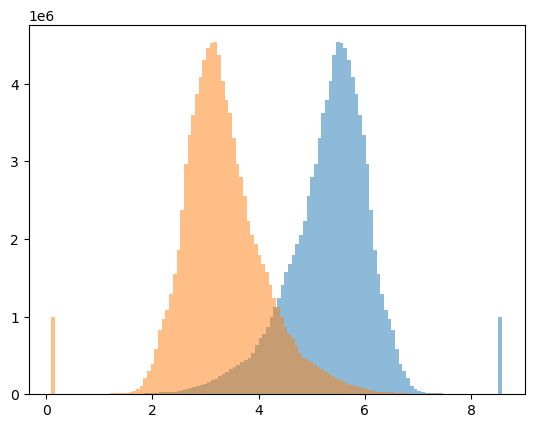

In [125]:
_ =plt.hist(Q_eff,bins=100, alpha=0.5)
_ =plt.hist(Q_be8_decay,bins=100, alpha=0.5)

<Axes: xlabel='en_a_01', ylabel='en_a_11'>

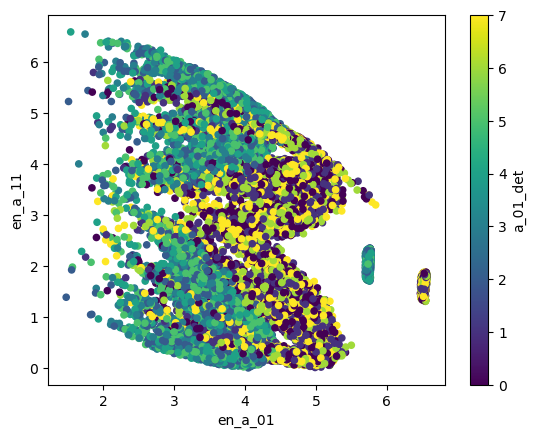

In [181]:
(alpha_df.loc[(alpha_df["multiple_det"] == True)]).plot.scatter(x="en_a_01",y="en_a_11",c="a_01_det")

# (alpha_df.loc[(alpha_df["multiple_det"] == True)]).plot.scatter(["en_a_01"],["en_a_12"])

# (alpha_df.loc[(alpha_df["multiple_det"] == True)]).plot.scatter(["en_a_11"],["en_a_12"])

# #(alpha_df.loc[(alpha_df["multiple_det"] == True) & (alpha_df["a_1_det"] == 6.0) & 
# #             (alpha_df["a_11_det"] == 1.0)]).plot.scatter(["en_a_01"],["en_a_11"])

In [ ]:
plt.scatter()

In [ ]:
# Saves to a .csv file.
#alpha_df.loc[(alpha_df["multiple_det"] == True)].to_csv('0p66MeVCoincidence.csv',na_rep='NaN',index=True)

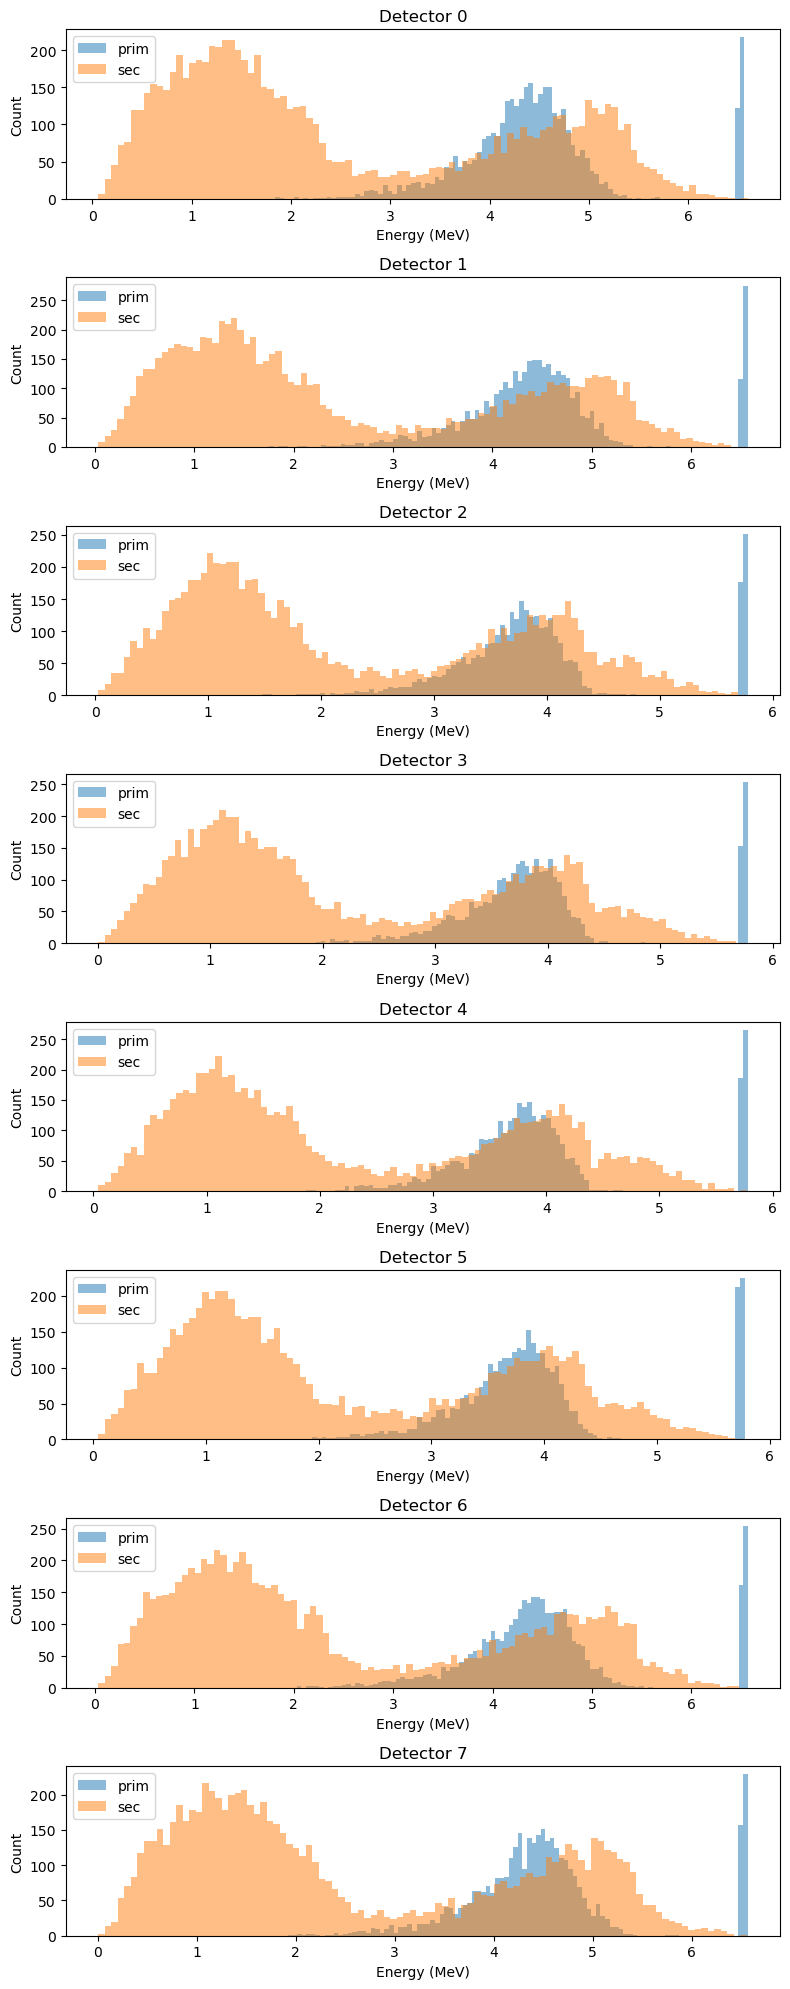

In [114]:
# Create a histogram of the energies of alpha particles that hit detector 0
fig, ax = plt.subplots(8,figsize=(8,20))
for i_det in np.arange(8):
    # Concatenate the energies of alpha particles that hit multiple detectors
    prim_detector = (alpha_df.loc[(alpha_df["a_01_det"] == i_det) & (alpha_df["multiple_det"] == True)].en_a_01)
    sec_detector = np.concatenate((
        alpha_df.loc[(alpha_df["a_11_det"] == i_det) & (alpha_df["multiple_det"] == True)].en_a_11,
        alpha_df.loc[(alpha_df["a_12_det"] == i_det) & (alpha_df["multiple_det"] == True)].en_a_12
    ))

    ax[i_det].hist(prim_detector, bins=100, label="prim",alpha=0.5)
    ax[i_det].hist(sec_detector, bins=100, label="sec",alpha=0.5)
    ax[i_det].legend()
    ax[i_det].set_xlabel('Energy (MeV)')
    ax[i_det].set_ylabel('Count')
    ax[i_det].set_title('Detector '+str(i_det))

fig.tight_layout()
plt.show()

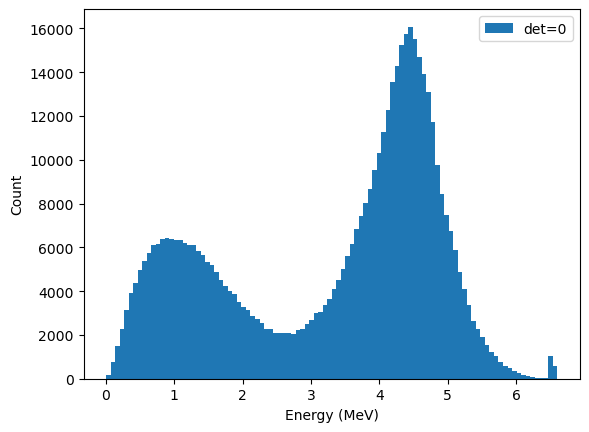

In [116]:
# Concatenate the energies of alpha particles that hit detector 0 and had multiple hits
detector_0 = np.concatenate((
    alpha_df.loc[(alpha_df["a_01_det"] == 0)].en_a_01,
    alpha_df.loc[(alpha_df["a_11_det"] == 0)].en_a_11,
    alpha_df.loc[(alpha_df["a_12_det"] == 0)].en_a_12
))

# Create a histogram of the energies of alpha particles that hit detector 0
fig, ax = plt.subplots()
ax.hist(detector_0, bins=100, label="det=0")
ax.legend()
ax.set_xlabel('Energy (MeV)')
ax.set_ylabel('Count')
plt.show()

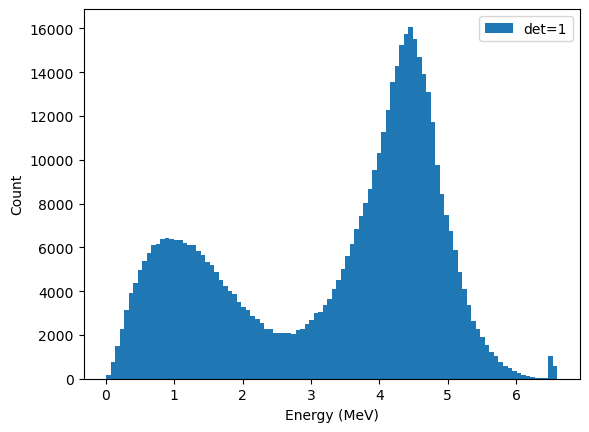

In [117]:
# Concatenate the energies of alpha particles that hit detector 1 and had multiple hits
detector_1 = np.concatenate((
    alpha_df.loc[(alpha_df["a_01_det"] == 1)].en_a_01,
    alpha_df.loc[(alpha_df["a_11_det"] == 1)].en_a_11,
    alpha_df.loc[(alpha_df["a_12_det"] == 1)].en_a_12
))

# Create a histogram of the energies of alpha particles that hit detector 1
fig, ax = plt.subplots()
ax.hist(detector_0, bins=100, label="det=1")
ax.legend()
ax.set_xlabel('Energy (MeV)')
ax.set_ylabel('Count')
plt.show()

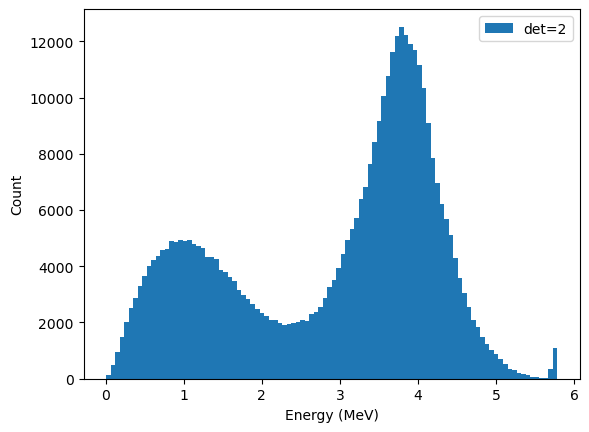

In [118]:
# Concatenate the energies of alpha particles that hit detector 2 and had multiple hits
detector_2 = np.concatenate((
    alpha_df.loc[(alpha_df["a_01_det"] == 2)].en_a_01,
    alpha_df.loc[(alpha_df["a_11_det"] == 2)].en_a_11,
    alpha_df.loc[(alpha_df["a_12_det"] == 2)].en_a_12
))

# Create a histogram of the energies of alpha particles that hit detector 2
fig, ax = plt.subplots()
ax.hist(detector_2, bins=100, label="det=2")
ax.legend()
ax.set_xlabel('Energy (MeV)')
ax.set_ylabel('Count')
plt.show()

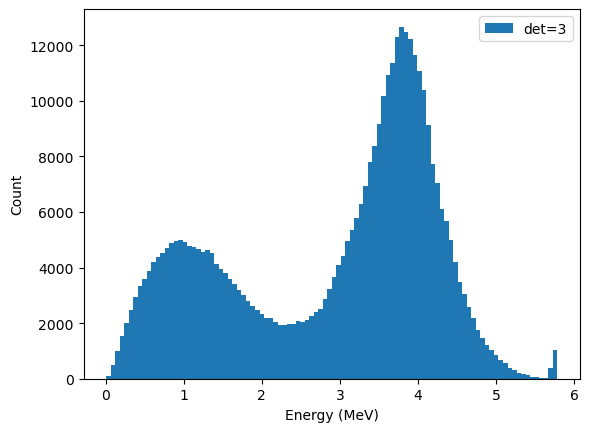

In [119]:
# Concatenate the energies of alpha particles that hit detector 3 and had multiple hits
detector_3 = np.concatenate((
    alpha_df.loc[(alpha_df["a_01_det"] == 3)].en_a_01,
    alpha_df.loc[(alpha_df["a_11_det"] == 3)].en_a_11,
    alpha_df.loc[(alpha_df["a_12_det"] == 3)].en_a_12
))

# Create a histogram of the energies of alpha particles that hit detector 3
fig, ax = plt.subplots()
ax.hist(detector_3, bins=100, label="det=3")
ax.legend()
ax.set_xlabel('Energy (MeV)')
ax.set_ylabel('Count')
plt.show()

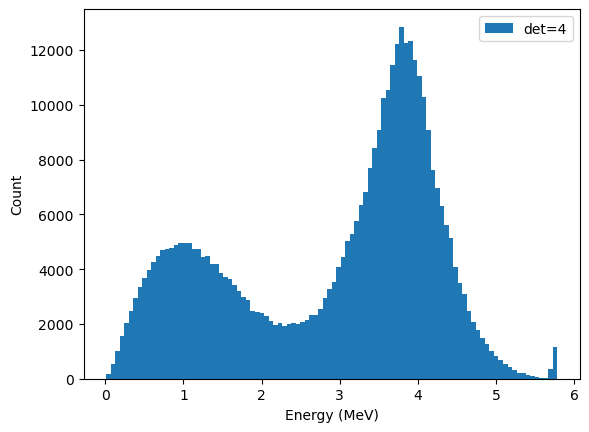

In [120]:
# Concatenate the energies of alpha particles that hit detector 4 and had multiple hits
detector_4 = np.concatenate((
    alpha_df.loc[(alpha_df["a_01_det"] == 4)].en_a_01,
    alpha_df.loc[(alpha_df["a_11_det"] == 4)].en_a_11,
    alpha_df.loc[(alpha_df["a_12_det"] == 4)].en_a_12
))

# Create a histogram of the energies of alpha particles that hit detector 4
fig, ax = plt.subplots()
ax.hist(detector_4, bins=100, label="det=4")
ax.legend()
ax.set_xlabel('Energy (MeV)')
ax.set_ylabel('Count')
plt.show()

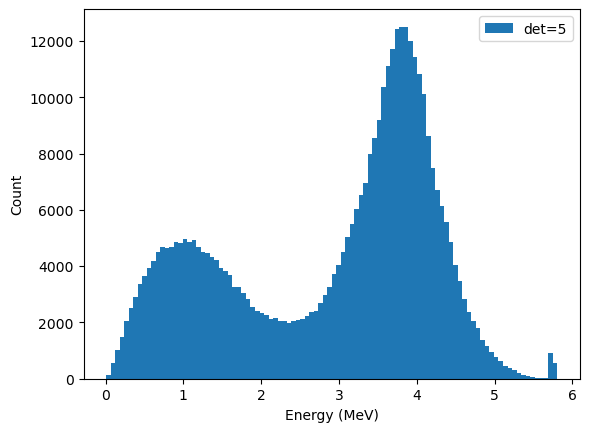

In [121]:
# Concatenate the energies of alpha particles that hit detector 5 and had multiple hits
detector_5 = np.concatenate((
    alpha_df.loc[(alpha_df["a_01_det"] == 5)].en_a_01,
    alpha_df.loc[(alpha_df["a_11_det"] == 5)].en_a_11,
    alpha_df.loc[(alpha_df["a_12_det"] == 5)].en_a_12
))

# Create a histogram of the energies of alpha particles that hit detector 5
fig, ax = plt.subplots()
ax.hist(detector_5, bins=100, label="det=5")
ax.legend()
ax.set_xlabel('Energy (MeV)')
ax.set_ylabel('Count')
plt.show()

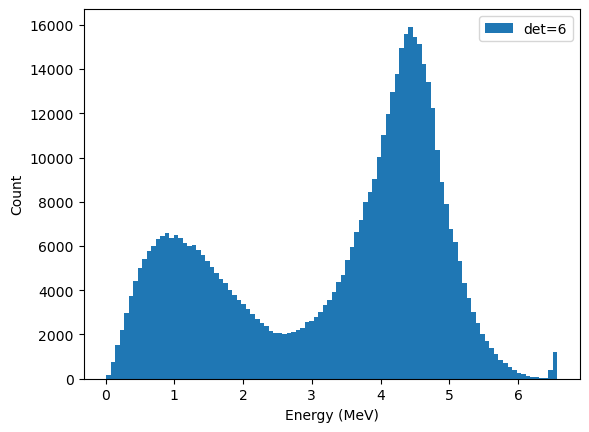

In [122]:
# Concatenate the energies of alpha particles that hit detector 6 and had multiple hits
detector_6 = np.concatenate((
    alpha_df.loc[(alpha_df["a_01_det"] == 6)].en_a_01,
    alpha_df.loc[(alpha_df["a_11_det"] == 6)].en_a_11,
    alpha_df.loc[(alpha_df["a_12_det"] == 6)].en_a_12
))

# Create a histogram of the energies of alpha particles that hit detector 6
fig, ax = plt.subplots()
ax.hist(detector_6, bins=100, label="det=6")
ax.legend()
ax.set_xlabel('Energy (MeV)')
ax.set_ylabel('Count')
plt.show()

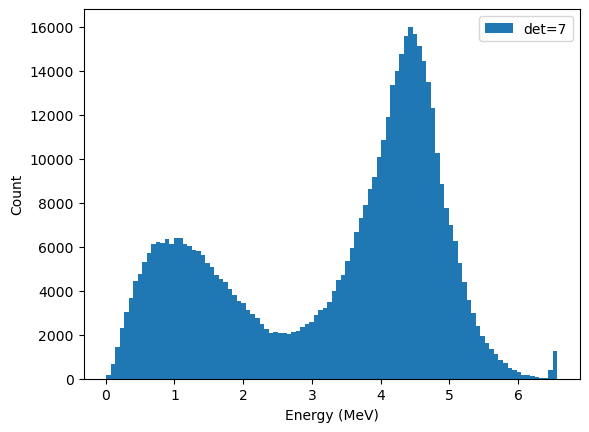

In [123]:
# Concatenate the energies of alpha particles that hit detector 7 and had multiple hits
detector_7 = np.concatenate((
    alpha_df.loc[(alpha_df["a_01_det"] == 7)].en_a_01,
    alpha_df.loc[(alpha_df["a_11_det"] == 7)].en_a_11,
    alpha_df.loc[(alpha_df["a_12_det"] == 7)].en_a_12
))

# Create a histogram of the energies of alpha particles that hit detector 6
fig, ax = plt.subplots()
ax.hist(detector_7, bins=100, label="det=7")
ax.legend()
ax.set_xlabel('Energy (MeV)')
ax.set_ylabel('Count')
plt.show()

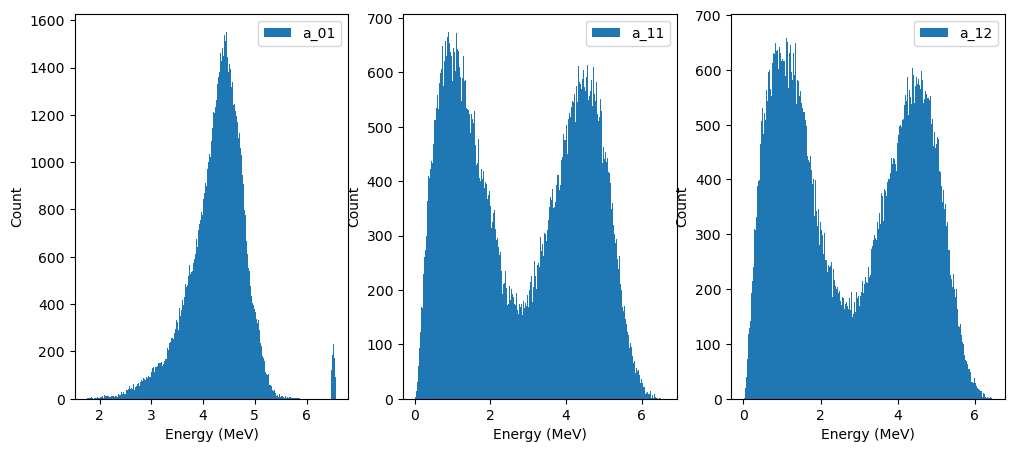

In [124]:
# Concatenate the energies of alpha particles that hit detector 0 and had multiple hits
det0_a01 = alpha_df.loc[(alpha_df["a_01_det"] == 0)].en_a_01
det0_a11 = alpha_df.loc[(alpha_df["a_11_det"] == 0)].en_a_11
det0_a12 = alpha_df.loc[(alpha_df["a_12_det"] == 0)].en_a_12

# Create a histogram of the energies of alpha particles that hit detector 0
fig, ax = plt.subplots(1,3, figsize=(12, 5))

ax[0].hist(det0_a01, bins=500, label="a_01")
ax[0].set_xlabel('Energy (MeV)')
ax[0].set_ylabel('Count')
ax[0].legend()

ax[1].hist(det0_a11, bins=500, label="a_11")
ax[1].set_xlabel('Energy (MeV)')
ax[1].set_ylabel('Count')
ax[1].legend()


ax[2].hist(det0_a12, bins=500, label="a_12")
ax[2].set_xlabel('Energy (MeV)')
ax[2].set_ylabel('Count')
ax[2].legend()



plt.show()

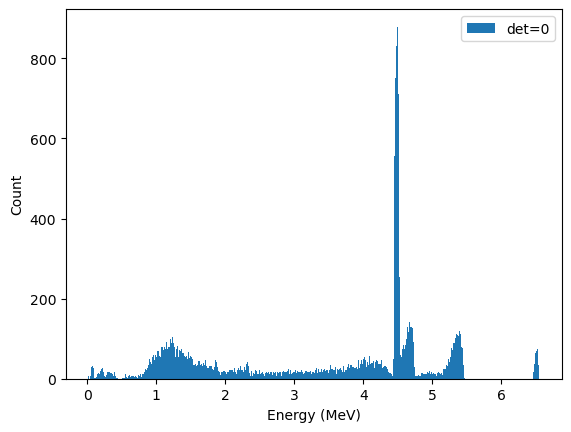

In [13]:
# Concatenate the energies of alpha particles that hit detector 0 and had multiple hits
detector_0 = np.concatenate((
    alpha_df.loc[(alpha_df["multiple_det"] == True) & (alpha_df["a_01_det"] == 0)].en_a_01,
    alpha_df.loc[(alpha_df["multiple_det"] == True) & (alpha_df["a_11_det"] == 0)].en_a_11,
    alpha_df.loc[(alpha_df["multiple_det"] == True) & (alpha_df["a_12_det"] == 0)].en_a_12
))

# Create a histogram of the energies of alpha particles that hit detector 0
fig, ax = plt.subplots()
ax.hist(detector_0, bins=500, label="det=0")
ax.legend()
ax.set_xlabel('Energy (MeV)')
ax.set_ylabel('Count')
plt.show()

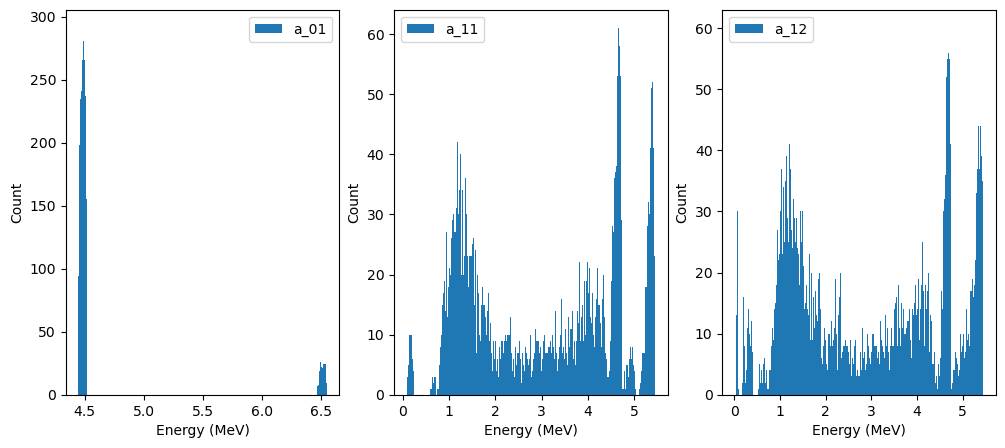

In [14]:
# Concatenate the energies of alpha particles that hit detector 0 and had multiple hits
det0_a01 = alpha_df.loc[(alpha_df["multiple_det"] == True) & (alpha_df["a_01_det"] == 0)].en_a_01
det0_a11 = alpha_df.loc[(alpha_df["multiple_det"] == True) & (alpha_df["a_11_det"] == 0)].en_a_11
det0_a12 = alpha_df.loc[(alpha_df["multiple_det"] == True) & (alpha_df["a_12_det"] == 0)].en_a_12

# Create a histogram of the energies of alpha particles that hit detector 0
fig, ax = plt.subplots(1,3, figsize=(12, 5))

ax[0].hist(det0_a01, bins=500, label="a_01")
ax[0].set_xlabel('Energy (MeV)')
ax[0].set_ylabel('Count')
ax[0].legend()

ax[1].hist(det0_a11, bins=500, label="a_11")
ax[1].set_xlabel('Energy (MeV)')
ax[1].set_ylabel('Count')
ax[1].legend()


ax[2].hist(det0_a12, bins=500, label="a_12")
ax[2].set_xlabel('Energy (MeV)')
ax[2].set_ylabel('Count')
ax[2].legend()



plt.show()

In [14]:
len(detector_0)

17381

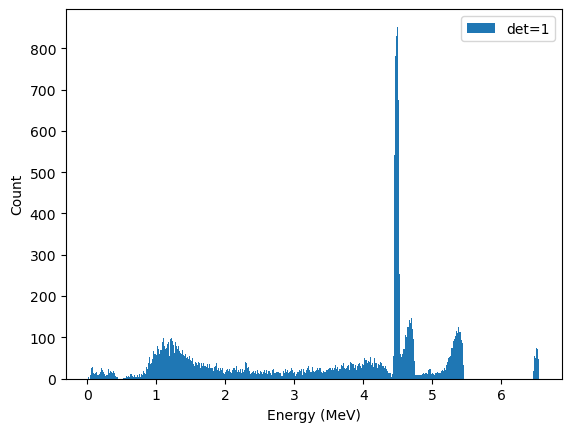

In [15]:
# Concatenate the energies of alpha particles that hit detector 1 and had multiple hits
detector_1 = np.concatenate((
    alpha_df.loc[(alpha_df["multiple_det"] == True) & (alpha_df["a_01_det"] == 1)].en_a_01,
    alpha_df.loc[(alpha_df["multiple_det"] == True) & (alpha_df["a_11_det"] == 1)].en_a_11,
    alpha_df.loc[(alpha_df["multiple_det"] == True) & (alpha_df["a_12_det"] == 1)].en_a_12
))

# Create a histogram of the energies of alpha particles that hit detector 1
fig, ax = plt.subplots()
ax.hist(detector_1, bins=500, label="det=1")
ax.legend()
ax.set_xlabel('Energy (MeV)')
ax.set_ylabel('Count')
plt.show()

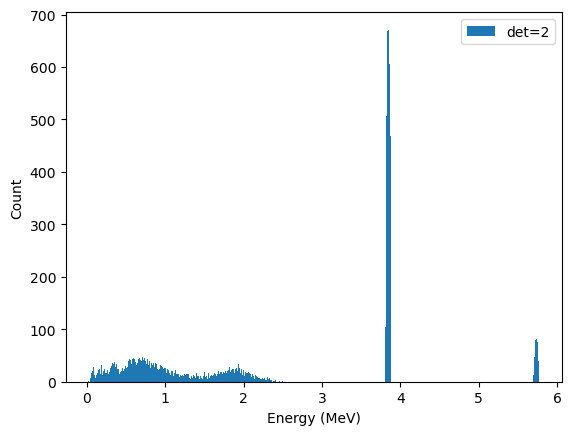

In [16]:
# Concatenate the energies of alpha particles that hit detector 2 and had multiple hits
detector_2 = np.concatenate((
    alpha_df.loc[(alpha_df["multiple_det"] == True) & (alpha_df["a_01_det"] == 2)].en_a_01,
    alpha_df.loc[(alpha_df["multiple_det"] == True) & (alpha_df["a_11_det"] == 2)].en_a_11,
    alpha_df.loc[(alpha_df["multiple_det"] == True) & (alpha_df["a_12_det"] == 2)].en_a_12
))

# Create a histogram of the energies of alpha particles that hit detector 2
fig, ax = plt.subplots()
ax.hist(detector_2, bins=500, label="det=2")
ax.legend()
ax.set_xlabel('Energy (MeV)')
ax.set_ylabel('Count')
plt.show()

In [17]:
len(detector_2)

7565

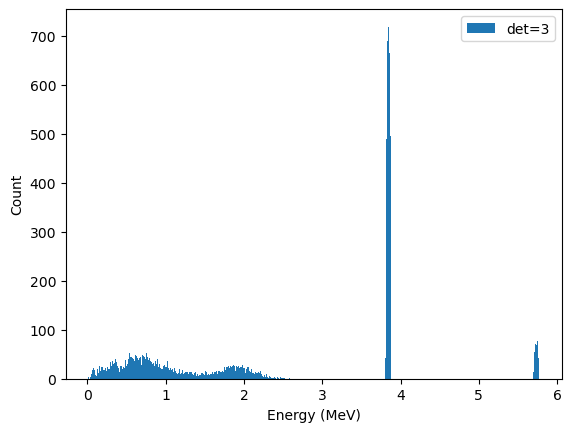

In [18]:
# Concatenate the energies of alpha particles that hit detector 3 and had multiple hits
detector_3 = np.concatenate((
    alpha_df.loc[(alpha_df["multiple_det"] == True) & (alpha_df["a_01_det"] == 3)].en_a_01,
    alpha_df.loc[(alpha_df["multiple_det"] == True) & (alpha_df["a_11_det"] == 3)].en_a_11,
    alpha_df.loc[(alpha_df["multiple_det"] == True) & (alpha_df["a_12_det"] == 3)].en_a_12
))

# Create a histogram of the energies of alpha particles that hit detector 3
fig, ax = plt.subplots()
ax.hist(detector_3, bins=500, label="det=3")
ax.legend()
ax.set_xlabel('Energy (MeV)')
ax.set_ylabel('Count')
plt.show()

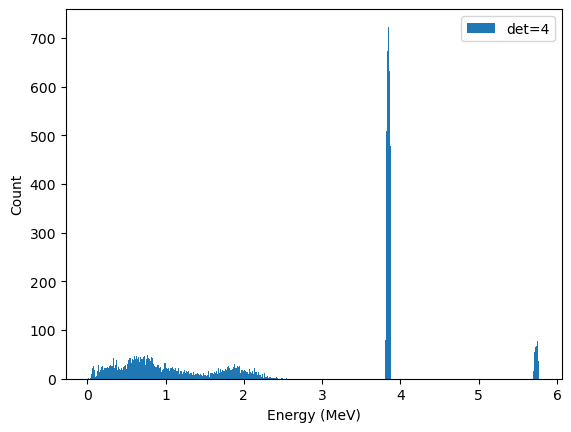

In [19]:
# Concatenate the energies of alpha particles that hit detector 4 and had multiple hits
detector_4 = np.concatenate((
    alpha_df.loc[(alpha_df["multiple_det"] == True) & (alpha_df["a_01_det"] == 4)].en_a_01,
    alpha_df.loc[(alpha_df["multiple_det"] == True) & (alpha_df["a_11_det"] == 4)].en_a_11,
    alpha_df.loc[(alpha_df["multiple_det"] == True) & (alpha_df["a_12_det"] == 4)].en_a_12
))

# Create a histogram of the energies of alpha particles that hit detector 4
fig, ax = plt.subplots()
ax.hist(detector_4, bins=500, label="det=4")
ax.legend()
ax.set_xlabel('Energy (MeV)')
ax.set_ylabel('Count')
plt.show()

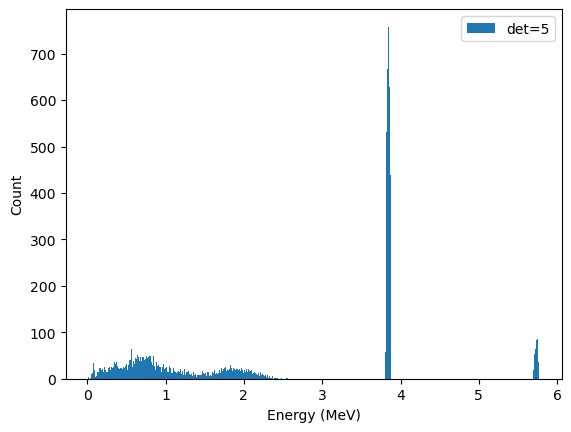

In [20]:
# Concatenate the energies of alpha particles that hit detector 5 and had multiple hits
detector_5 = np.concatenate((
    alpha_df.loc[(alpha_df["multiple_det"] == True) & (alpha_df["a_01_det"] == 5)].en_a_01,
    alpha_df.loc[(alpha_df["multiple_det"] == True) & (alpha_df["a_11_det"] == 5)].en_a_11,
    alpha_df.loc[(alpha_df["multiple_det"] == True) & (alpha_df["a_12_det"] == 5)].en_a_12
))

# Create a histogram of the energies of alpha particles that hit detector 5
fig, ax = plt.subplots()
ax.hist(detector_5, bins=500, label="det=5")
ax.legend()
ax.set_xlabel('Energy (MeV)')
ax.set_ylabel('Count')
plt.show()

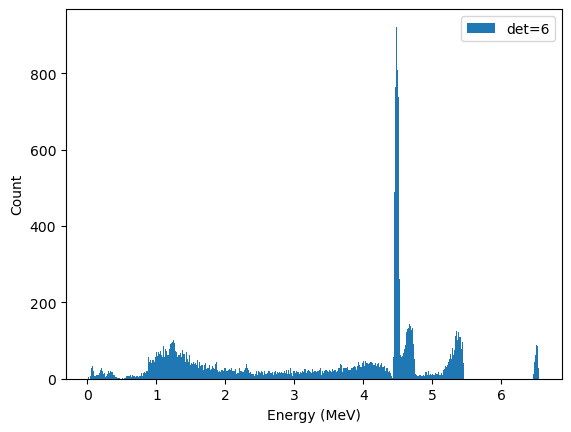

In [21]:
# Concatenate the energies of alpha particles that hit detector 6 and had multiple hits
detector_6 = np.concatenate((
    alpha_df.loc[(alpha_df["multiple_det"] == True) & (alpha_df["a_01_det"] == 6)].en_a_01,
    alpha_df.loc[(alpha_df["multiple_det"] == True) & (alpha_df["a_11_det"] == 6)].en_a_11,
    alpha_df.loc[(alpha_df["multiple_det"] == True) & (alpha_df["a_12_det"] == 6)].en_a_12
))

# Create a histogram of the energies of alpha particles that hit detector 6
fig, ax = plt.subplots()
ax.hist(detector_6, bins=500, label="det=6")
ax.legend()
ax.set_xlabel('Energy (MeV)')
ax.set_ylabel('Count')
plt.show()

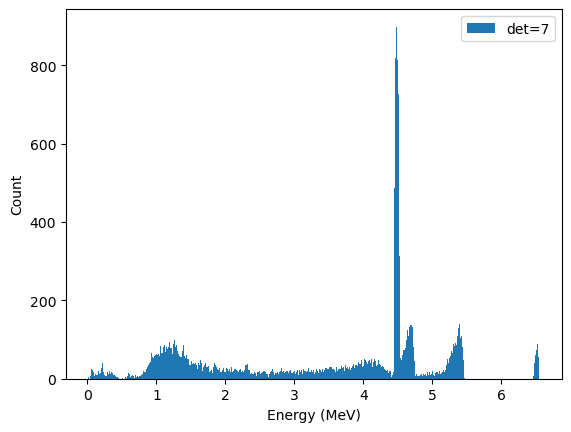

In [22]:
# Concatenate the energies of alpha particles that hit detector 7 and had multiple hits
detector_7 = np.concatenate((
    alpha_df.loc[(alpha_df["multiple_det"] == True) & (alpha_df["a_01_det"] == 7)].en_a_01,
    alpha_df.loc[(alpha_df["multiple_det"] == True) & (alpha_df["a_11_det"] == 7)].en_a_11,
    alpha_df.loc[(alpha_df["multiple_det"] == True) & (alpha_df["a_12_det"] == 7)].en_a_12
))

# Create a histogram of the energies of alpha particles that hit detector 7
fig, ax = plt.subplots()
ax.hist(detector_7, bins=500, label="det=7")
ax.legend()
ax.set_xlabel('Energy (MeV)')
ax.set_ylabel('Count')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

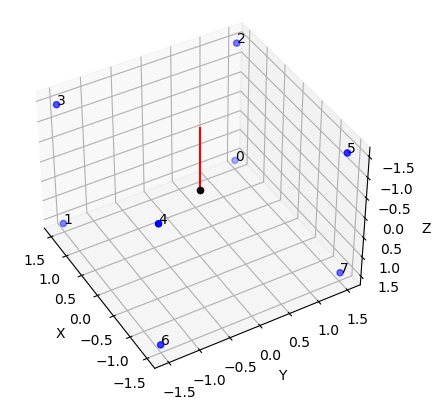

In [23]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

#detectors
ax.scatter3D(detector_x, detector_y, detector_z, c="blue")

det_num = np.arange(len(detector_x))

for x,y,z,s in zip(detector_x, detector_y, detector_z, det_num):
    ax.text(x, y, z, s)

# ax.plot3D([0, a10_x[0]], [0, a10_y[0]], [0, a10_z[0]], "green")
# ax.plot3D([0, Be_x[0]],[0, Be_y[0]],[0, Be_z[0]], "red")

# ax.plot3D([0, a11_x[0]],[0, a11_y[0]],[0, a11_z[0]], "orange")
# ax.plot3D([0, a12_x[0]],[0, a12_y[0]],[0, a12_z[0]], "pink")

# ax.scatter3D(rx, ry, rz, "green")
# ax.plot3D(rx, ry, rz, "green")

# ax.scatter3D(0, 0, 0, "red")

ax.plot3D([0,0],[0,0],[0,-max(detector_z)], "red")

ax.scatter3D(0,0,0, c="black")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.view_init(-140, 30)

plt.show

0.7071067811865475

<function matplotlib.pyplot.show(close=None, block=None)>

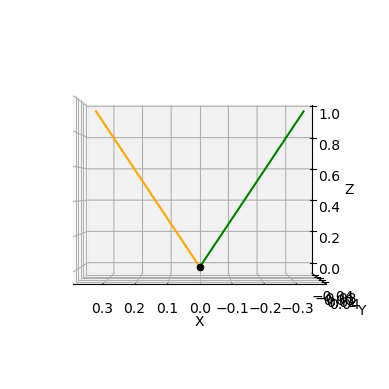

In [156]:
d = 1.0
theta_L1 = np.array([20.0])
phi_L1 = np.array([20.0])

# Convert to 3D coordinates
# First reaction
alpha_01_x, alpha_01_y, alpha_01_z = convert_to_cartesian_zx(d, theta_L1)
Be8_x, Be8_y, Be8_z = convert_to_cartesian_zx(d, 360 - phi_L1)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.plot3D([0,alpha_01_x[0]],[0,alpha_01_y[0]],[0,alpha_01_z[0]], "orange")
ax.plot3D([0,Be8_x[0]],[0,Be8_y[0]],[0,Be8_z[0]], "green")

ax.scatter3D(0,0,0, c="black")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.view_init(0, 90)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

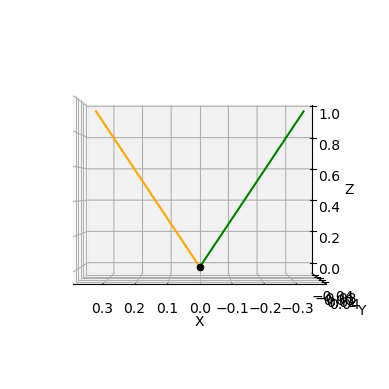

In [157]:
r1_phiL = np.array([0.0])

# Rotate the coordinate system for the first reaction
alpha_01_x, alpha_01_y, alpha_01_z = rotate_z(alpha_01_x, alpha_01_y, alpha_01_z, r1_phiL)
Be8_x, Be8_y, Be8_z = rotate_z(Be8_x, Be8_y, Be8_z, r1_phiL)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.plot3D([0,alpha_01_x[0]],[0,alpha_01_y[0]],[0,alpha_01_z[0]], "orange")
ax.plot3D([0,Be8_x[0]],[0,Be8_y[0]],[0,Be8_z[0]], "green")

ax.scatter3D(0,0,0, c="black")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.view_init(0, 90)

plt.show

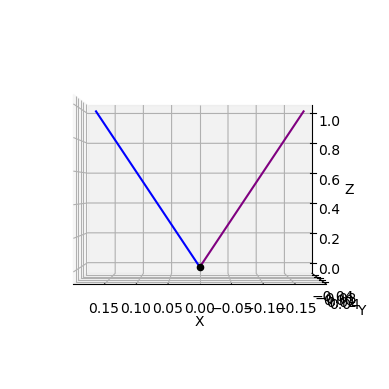

In [158]:
theta_L2 = np.array([10])
phi_L2 = np.array([10])

# Second reaction

# Convert spherical coordinates to Cartesian coordinates for alpha particles 11 and 12
alpha_11_x, alpha_11_y, alpha_11_z = convert_to_cartesian_zx(d, theta_L2)
alpha_12_x, alpha_12_y, alpha_12_z = convert_to_cartesian_zx(d, 360 - phi_L2)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.plot3D([0,alpha_11_x[0]],[0,alpha_11_y[0]],[0,alpha_11_z[0]], "blue")
ax.plot3D([0,alpha_12_x[0]],[0,alpha_12_y[0]],[0,alpha_12_z[0]], "purple")

ax.scatter3D(0,0,0, c="black")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.view_init(0, 90)

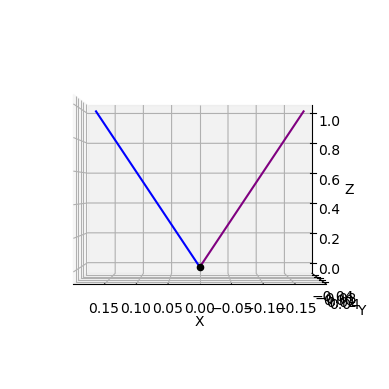

In [159]:
r2_phiL = np.array([0])

# Rotate the coordinate system for the second reaction
alpha_11_x, alpha_11_y, alpha_11_z = rotate_z(alpha_11_x, alpha_11_y, alpha_11_z, r2_phiL)
alpha_12_x, alpha_12_y, alpha_12_z = rotate_z(alpha_12_x, alpha_12_y, alpha_12_z, r2_phiL)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.plot3D([0,alpha_11_x[0]],[0,alpha_11_y[0]],[0,alpha_11_z[0]], "blue")
ax.plot3D([0,alpha_12_x[0]],[0,alpha_12_y[0]],[0,alpha_12_z[0]], "purple")

ax.scatter3D(0,0,0, c="black")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.view_init(0, 90)

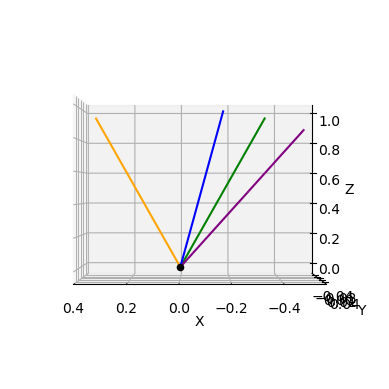

In [160]:
# Align alphas with Be8
alpha_11_x, alpha_11_y, alpha_11_z = rotate_y(alpha_11_x, alpha_11_y, alpha_11_z, phi_L1)
alpha_12_x, alpha_12_y, alpha_12_z = rotate_y(alpha_12_x, alpha_12_y, alpha_12_z, phi_L1)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.plot3D([0,alpha_01_x[0]],[0,alpha_01_y[0]],[0,alpha_01_z[0]], "orange")
ax.plot3D([0,Be8_x[0]],[0,Be8_y[0]],[0,Be8_z[0]], "green")

ax.plot3D([0,alpha_11_x[0]],[0,alpha_11_y[0]],[0,alpha_11_z[0]], "blue")
ax.plot3D([0,alpha_12_x[0]],[0,alpha_12_y[0]],[0,alpha_12_z[0]], "purple")

ax.scatter3D(0,0,0, c="black")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.view_init(0, 90)

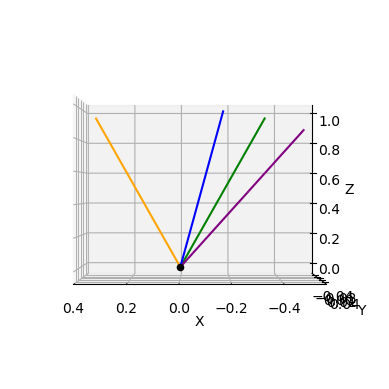

In [161]:
alpha_11_x, alpha_11_y, alpha_11_z = rotate_z(alpha_11_x, alpha_11_y, alpha_11_z, r1_phiL)
alpha_12_x, alpha_12_y, alpha_12_z = rotate_z(alpha_12_x, alpha_12_y, alpha_12_z, r1_phiL)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.plot3D([0,alpha_01_x[0]],[0,alpha_01_y[0]],[0,alpha_01_z[0]], "orange")
ax.plot3D([0,Be8_x[0]],[0,Be8_y[0]],[0,Be8_z[0]], "green")

ax.plot3D([0,alpha_11_x[0]],[0,alpha_11_y[0]],[0,alpha_11_z[0]], "blue")
ax.plot3D([0,alpha_12_x[0]],[0,alpha_12_y[0]],[0,alpha_12_z[0]], "purple")

ax.scatter3D(0,0,0, c="black")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.view_init(0, 90)

In [20]:
atoms_per_area

1.3091000000000003e+18

In [8]:
diff_cross_section(zp, zB, mp, mB11, enp, 45)

3.4659480572842456e-24

In [26]:
solid_angle(d, detector_area)

0.01899718381792446

In [19]:
diff_cross_section(zp, zB, mp, mB11, enp, 45)*solid_angle(d, detector_area)*atoms_per_area

8.619540164825234e-08

In [23]:
enp*kinematic_factor(mp,mB11,45)

0.6255210286895171

In [17]:
diff_cross_section(zp, zB, mp, mB11, enp, 135)

1.0082097682801677e-25

In [18]:
diff_cross_section(zp, zB, mp, mB11, enp, 135)*solid_angle(d, detector_area)*atoms_per_area

2.50733838148439e-09

In [24]:
enp*kinematic_factor(mp,mB11,135)

0.482458840549031

In [6]:
diff_cross_section(zp, zB, mp, mB11, enp, 41.05)

4.91925799749787e-24

In [7]:
diff_cross_section(zp, zB, mp, mB11, enp, 48.95)

2.5227763066393654e-24

In [82]:
import numpy as np
from scipy.special import sph_harm

l = 3
theta = np.linspace(0, np.pi, 3)  # theta in [0, pi]
phi = np.linspace(0, 2 * np.pi, 3)  # phi in [0, 2*pi]
theta_grid, phi_grid = np.meshgrid(theta, phi)

# Initialize probability density to zeros
total_prob_density = np.zeros_like(theta_grid)

# Sum over all allowed m values
for m in range(-l, l + 1):
    total_prob_density += np.abs(sph_harm(m, l, phi_grid, theta_grid))**2
    #print(total_prob_density) 

# Normalize probability density
#total_prob_density /= np.sum(total_prob_density)

 # This should now vary over theta and phi

print(total_prob_density)


[[0.5570423 0.5570423 0.5570423]
 [0.5570423 0.5570423 0.5570423]
 [0.5570423 0.5570423 0.5570423]]


In [76]:
np.abs(sph_harm(m, l, phi_grid, theta_grid))**2

array([[0.        , 0.14920776, 0.        ],
       [0.        , 0.14920776, 0.        ],
       [0.        , 0.14920776, 0.        ]])

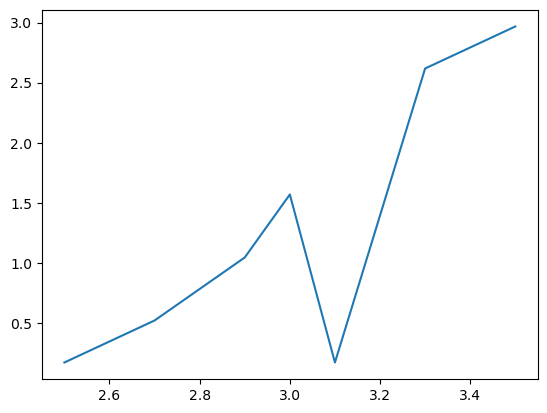

In [15]:
plt.plot(energy,phase_shifts)

In [23]:
excitation_weights

array([0.43010753, 0.53763441, 1.07526882, 1.07526882, 1.29032258,
       1.72043011, 0.43010753])